# Study of energy decay and how it is related to the formation of clusters

## Import libraries and dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections
from matplotlib import rc
import os
import sys
sys.path.append("../")

from scipy import stats
from scipy.optimize import curve_fit
from scipy.linalg import norm

from config import results_folder, plots_folder

## Plot details

In [2]:
plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 4
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath} \usepackage{bm}"]

## Utility functions

In [3]:
def read_and_return_energy_data(filenames, timestep, t_stop, runs):
    times = np.arange(0, (int(t_stop/timestep)+1))*timestep
    energy_matrix = np.zeros((runs, int(t_stop/timestep)+1))
    for i in range(runs):
        filename = filenames.replace('X', str(i))
        statistics_data = np.load(file=os.path.join(results_folder, filename))
        energy_matrix[i, :] = statistics_data[:, 1]
    return times, np.mean(energy_matrix, axis=0), np.std(energy_matrix, axis=0)

In [4]:
def haffs_cooling_law(t, tau):
    # scaled version: T/T0
    return (1+t/tau)**(-2)

def a2(d, xi):
    return 16*(1-xi)*(1-2*xi**2)/(9+24*d+8*d*xi-41*xi+30*xi**2*(1-xi))

def tau_analytical(T0, xi, N, r, m=1):
    # Num and exp result China + Brilliantov and Poshel with a2=0
    n = N/1
    eta = n*4*np.pi*r**3/3
    g = (2-eta)/(2*(1-eta)**3)
    #a = a2(3, xi)
    a = 0
    #print(a)
    return (np.sqrt(T0/m)*(1-xi**2)/6*4*np.sqrt(np.pi)*g*(2*r)**2*n*(1+3*a/16))**(-1)

In [5]:
def check_convergence(times, avg, std, runs):
    # Error is given by Central limit theorem
    plt.figure()
    plt.loglog(times, std/np.sqrt(runs))
    plt.title('Standard deviation computed from clt')
    plt.show()

## Energy decay

In [6]:
def plot_energy(N, xi, rad, tstop, timestep, runs=4):
    print(f"--------------- xi: {xi} -------------------")
    #filenames = f"energy_development_pbc_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"
    filenames = f"simulation_statistics_pbc_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"
    print(filenames)
    
    times, energy_avg, energy_std = read_and_return_energy_data(filenames, timestep, tstop, runs)
    start_energy = energy_avg[0]
    T0 = energy_avg[0]*2/3
    times = times[1:]
    energy_avg = energy_avg[1:]
    energy_std = energy_std[1:]
    
    popt, pcov = curve_fit(haffs_cooling_law, times, energy_avg/start_energy)
    
    tau = tau_analytical(T0, xi, N, rad)
    
    check_convergence(times, energy_avg, energy_std, runs)

    print('Std info..')
    print(f"min: {min(energy_std)} max: {max(energy_std)}")
    print('error info..')
    print(f"min: {min(energy_std/np.sqrt(runs))} max: {max(energy_std/np.sqrt(runs))}")
    
    plt.figure()
    print(f'tau opt: {popt[0]} estimated: {tau}')
    plt.loglog(times, energy_avg/start_energy, label='Numerical values')
    plt.loglog(times, haffs_cooling_law(times, tau), 'k--', label='Theoretical values')
    plt.loglog(times, np.abs(energy_avg/start_energy-haffs_cooling_law(times, tau)), label='|Difference|')

    plt.xlabel(r'$t$')
    plt.ylabel(r'$\frac{T(t)}{T_0}$')
    #plt.title(r'$\xi={}$'.format(xi))
    plt.legend()
    plt.show()

In [7]:
def plot_energy_for_several_xi(N, xi_values, rad, tstop, timestep, runs=4):
    number_of_xis = len(xi_values)
    fig, axes = plt.subplots(nrows=number_of_xis, ncols=1, sharex=True, figsize=(10, 3*number_of_xis))
    
    for i in range(number_of_xis):
        xi = xi_values[i]
        #filenames = f"energy_development_pbc_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"
        filenames = f"simulation_statistics_pbc_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"
        print(filenames)
    
        times, energy_avg, energy_std = read_and_return_energy_data(filenames, timestep, tstop, runs)
        start_energy = energy_avg[0]
        T0 = energy_avg[0]*2/3
        times = times[1:]
        energy_avg = energy_avg[1:]
        energy_std = energy_std[1:]
    
        tau = tau_analytical(T0, xi, N, rad)

        axes[i].loglog(times, energy_avg/start_energy, label='Numerical values')
        axes[i].loglog(times, haffs_cooling_law(times, tau), 'k--', label='Theoretical values')
        axes[i].set_ylabel(r'$\frac{T(t)}{T_0}$')
        axes[i].set_title(r'$\xi={}$'.format(xi))
        axes[i].legend()

    axes[-1].set_xlabel(r'$t$')
    plt.tight_layout()
    plt.savefig(os.path.join(plots_folder, f'decay_of_energy_N_{N}_rad_{rad}.pdf'))
    plt.show()

In [8]:
def compare_bc(N, xi, rad, tstop, timestep, runs):
    print(f"--------------- xi: {xi} -------------------")
    filenames_1 = f"simulation_statistics_pbc_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"
    filenames_2 = f"simulation_statistics_rbc_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"
    filenames_3 = f"simulation_statistics_rbc_iew_N_{N}_xi_{xi}_tstop_{tstop}_lgtc_-inf_X.npy"
    filenames_list = [filenames_1, filenames_2, filenames_3]
    label_list = ['PBC', 'RBC', 'Inelastic RBC']
    
    plt.figure()
    
    for i in range(3):
        filenames = filenames_list[i]
        print(filenames)
    
        times, energy_avg, energy_std = read_and_return_energy_data(filenames, timestep, tstop, runs)
        start_energy = energy_avg[0]
        T0 = energy_avg[0]*2/3
        times = times[1:]
        energy_avg = energy_avg[1:]
        energy_std = energy_std[1:]

        plt.loglog(times, energy_avg/start_energy, label=label_list[i])
        
        tau = tau_analytical(T0, xi, N, rad)
    
    times = np.logspace(-1, np.log10(tstop), 30)
    plt.loglog(times, haffs_cooling_law(times, tau), 'k--', label='Theoretical values')
    
    plt.xlabel(r'$t$')
    plt.ylabel(r'$\frac{T(t)}{T_0}$')
    #plt.title(r'$\xi={}$'.format(xi))
    plt.legend()
    plt.savefig(os.path.join(plots_folder, f"decay_of_energy_bc_N_{N}_xi_{xi}_rad_{rad}.pdf"))
    plt.show()

## Numerical values

### Difference between pbc, rbc and rbc with inelastic walls

In [9]:
N = 1000
xi = 0.8
rad = 1/40
tstop = 100
timestep = 0.1
runs = 4

--------------- xi: 0.8 -------------------
simulation_statistics_pbc_N_1000_xi_0.8_tstop_100_lgtc_-inf_X.npy
simulation_statistics_rbc_N_1000_xi_0.8_tstop_100_lgtc_-inf_X.npy
simulation_statistics_rbc_iew_N_1000_xi_0.8_tstop_100_lgtc_-inf_X.npy


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


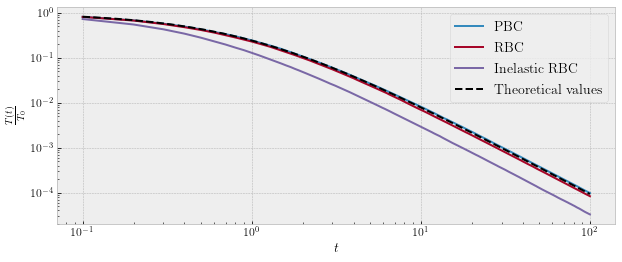

In [10]:
compare_bc(N, xi, rad, tstop, timestep, runs)

### Pbc for some different values of xi

--------------- xi: 0.99 -------------------
simulation_statistics_pbc_N_1000_xi_0.99_tstop_100_lgtc_-inf_X.npy


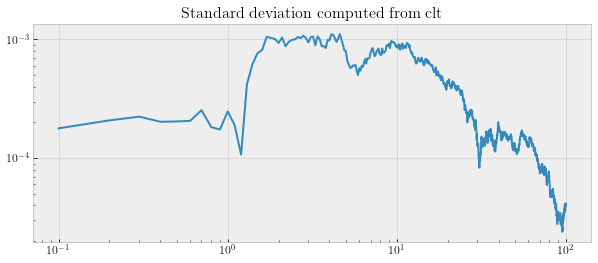

Std info..
min: 4.793174615307851e-05 max: 0.0022190322979214767
error info..
min: 2.3965873076539256e-05 max: 0.0011095161489607383
tau opt: 17.65532549871406 estimated: 17.584221970112576


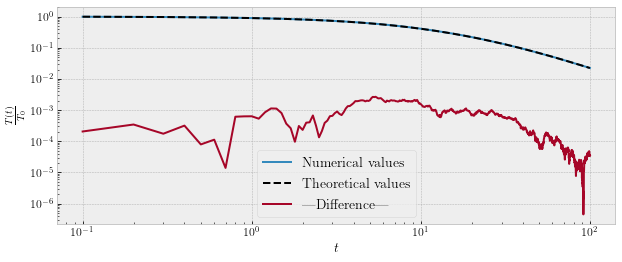

--------------- xi: 0.8 -------------------
simulation_statistics_pbc_N_1000_xi_0.8_tstop_100_lgtc_-inf_X.npy


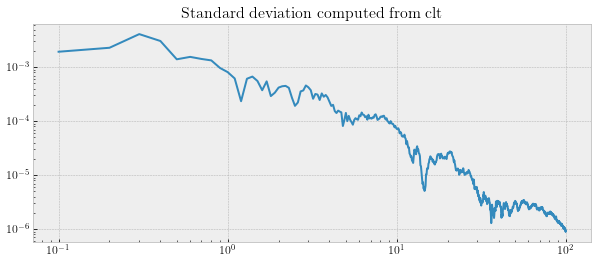

Std info..
min: 1.7845873967806498e-06 max: 0.008213159268934067
error info..
min: 8.922936983903249e-07 max: 0.0041065796344670336
tau opt: 0.9688318521753416 estimated: 0.9720167144590022


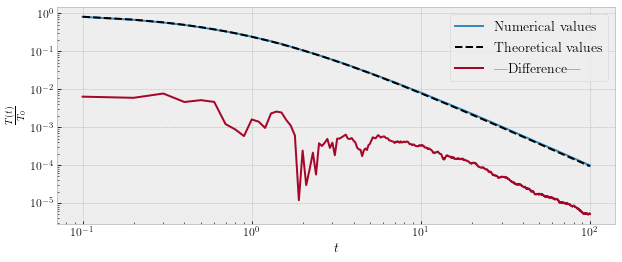

--------------- xi: 0.5 -------------------
simulation_statistics_pbc_N_1000_xi_0.5_tstop_100_lgtc_-inf_X.npy


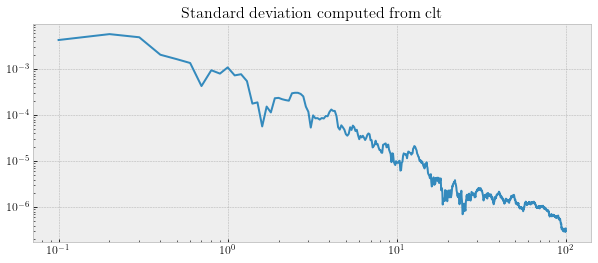

Std info..
min: 5.867184602301944e-07 max: 0.011471677520967304
error info..
min: 2.933592301150972e-07 max: 0.005735838760483652
tau opt: 0.4799038562145839 estimated: 0.466568022940321


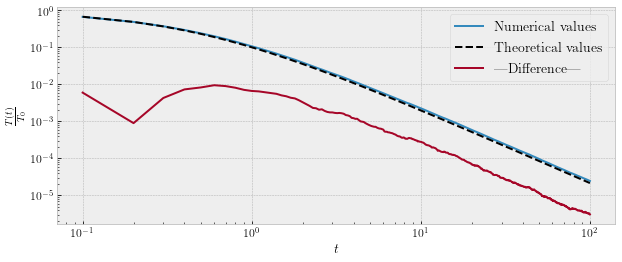

--------------- xi: 0.3 -------------------
simulation_statistics_pbc_N_1000_xi_0.3_tstop_100_lgtc_-inf_X.npy


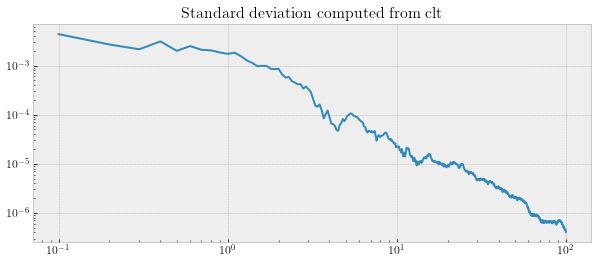

Std info..
min: 8.243990347920089e-07 max: 0.00873964332422395
error info..
min: 4.1219951739600447e-07 max: 0.004369821662111975
tau opt: 0.4030050629161093 estimated: 0.3845340848409239


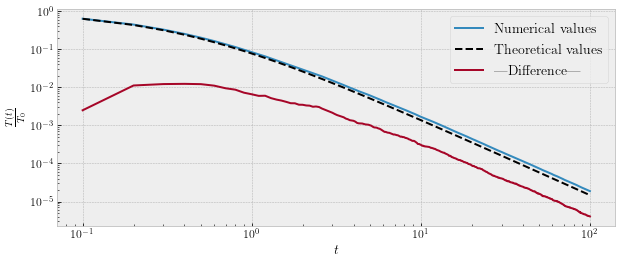

In [11]:
N = 1000
xi_values = [0.99, 0.8, 0.5, 0.3]
rad = 1/40
tstop = 100
timestep = 0.1

for xi in xi_values:
    plot_energy(N, xi, rad, tstop, timestep)

--------------- xi: 0.3 -------------------
simulation_statistics_pbc_N_1000_xi_0.3_tstop_1000_lgtc_-inf_X.npy


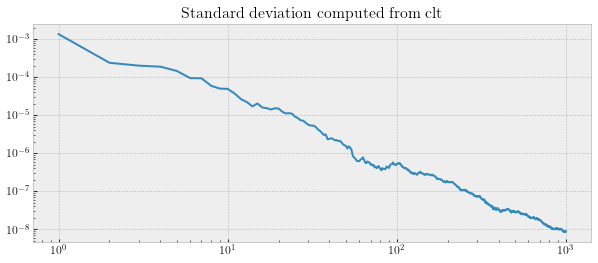

Std info..
min: 1.7229975806487516e-08 max: 0.0027202387998455572
error info..
min: 8.614987903243758e-09 max: 0.0013601193999227786
tau opt: 0.41002488538200477 estimated: 0.3845340848409239


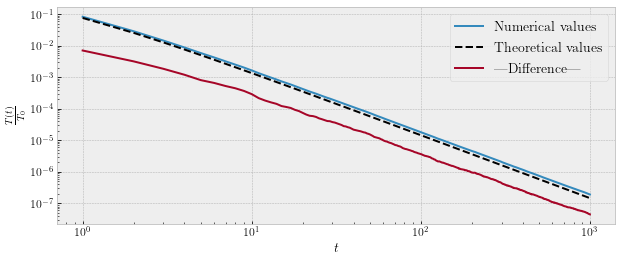

In [12]:
xi = 0.3
tstop = 1000
timestep = 1

plot_energy(N, xi, rad, tstop, timestep)

--------------- xi: 0.3 -------------------
simulation_statistics_pbc_N_1000_xi_0.3_tstop_10000_lgtc_-inf_X.npy


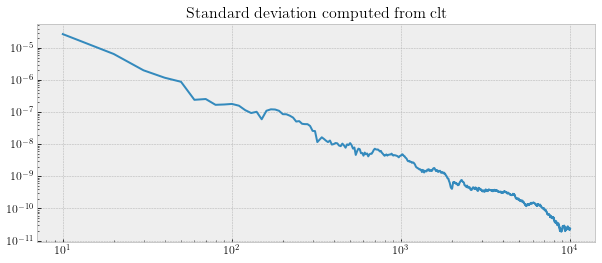

Std info..
min: 3.735972567056458e-11 max: 5.376825358155829e-05
error info..
min: 1.867986283528229e-11 max: 2.6884126790779145e-05
tau opt: 0.4144687540475465 estimated: 0.3845340848409239


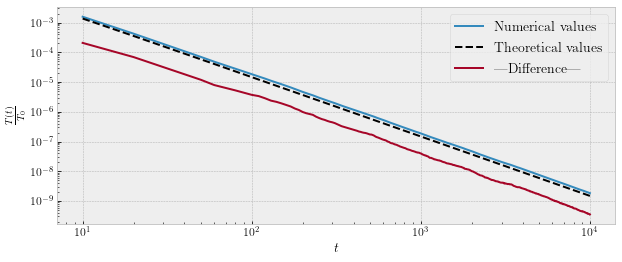

In [13]:
tstop = 10000
timestep = 10

plot_energy(N, xi, rad, tstop, timestep)

## Plot for report

simulation_statistics_pbc_N_1000_xi_0.99_tstop_100_lgtc_-inf_X.npy
simulation_statistics_pbc_N_1000_xi_0.5_tstop_100_lgtc_-inf_X.npy
simulation_statistics_pbc_N_1000_xi_0.3_tstop_100_lgtc_-inf_X.npy


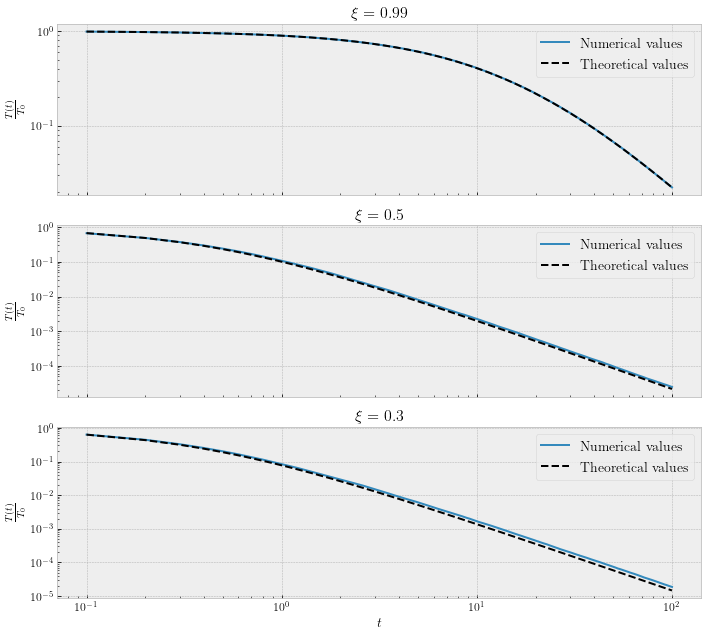

In [14]:
N = 1000
xi_values = [0.99, 0.5, 0.3]
rad = 1/40
tstop = 100
timestep = 0.1

plot_energy_for_several_xi(N, xi_values, rad, tstop, timestep)